In [1]:
"""
Demosaicking is an essential part in digital photography. 
While more people shoot photos with RAW format, few discusses
the workflow behind demosaicking.

This tutorial decomposes demosaicking process into 3 steps:
1. clip and scale - this step utilizes black and white level of an
image, scaling the RAW image into [0, 1]
2. color scale - this step utilizes rggb multiplier that metadata
specifies to scale color. This fixes the color balance of the image.
3. interpolation - this step takes single channel mosaic image as input, pack
the pixels into r, g, b channels.
4. gamma correction - this step inverses the gamma transformation the most
digital camera takes.
"""

"""
Most RAW file also come with compression, this is beyond the scope of this
tutorial.
You will need:
unprocessed_raw binary from LibRAW package to decode the RAW images.
exiftool to read rggb multipliers, black and white level from raw data.
"""

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
"""
Useful functions
"""

def show_hist(x, bins='auto', xlabel="pixel value", ylabel="count", normed=False, color = None):
    plt.hist(x, bins=bins, range=(x.min(), x.max()), normed=normed, color=color )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def print_region(x, patch = [5, 5], fro = [0, 0]):
    print (x[fro[0]:fro[0]+patch[0], fro[1]:fro[1]+patch[1]])

def print_region_rgb(x, p = [5, 5], f = [0, 0]):
    print ("r\n")
    print_region(x[:,:,0], p, f)
    print ("g\n")
    print_region(x[:,:,1], p, f)
    print ("b\n")
    print_region(x[:,:,2], p, f)

def gamma_correction(x, gamma = 2.2):
    return x**gamma

def normalize(x):
    return x / x.max()

Size:  (4024, 6048)
Total pixels:  24337152
Mean:  1450.46871647
Var:  8684743.36488
Min:  472
First Quartile:  572.0
Median:  680.0
Second Quartile:  844.0
Max:  16380


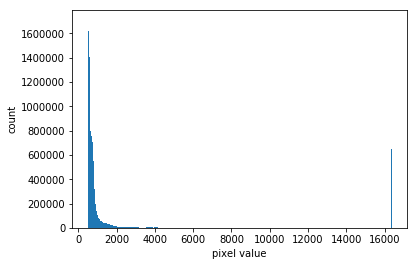

In [3]:
# Decoded by unprocessed_raw from libraw
unprocessed_raw = np.array(Image.open("/home/michael/Documents/test.pgm"))

print ("Size: ", unprocessed_raw.shape)
print ("Total pixels: ", unprocessed_raw.size)

print ("Mean: ", unprocessed_raw.mean())
print ("Var: ", unprocessed_raw.var())

print ("Min: ", unprocessed_raw.min())
print ("First Quartile: ", np.percentile(unprocessed_raw, 25))
print ("Median: ", np.median(unprocessed_raw))
print ("Second Quartile: ", np.percentile(unprocessed_raw, 75))
print ("Max: ", unprocessed_raw.max())

show_hist(unprocessed_raw.reshape([-1]), 1000)

unprocessed_raw = unprocessed_raw.astype("float64")

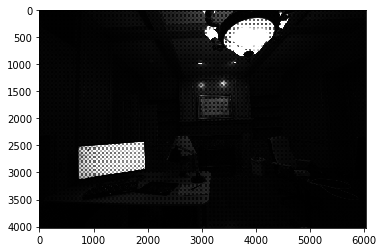

In [4]:
# Take a look at unprocessed raw.
plt.imshow(unprocessed_raw, cmap='gray')

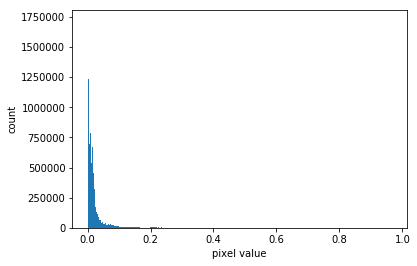

In [5]:
# From EXIFTOOL:
Black_level = 512
White_level = 15360


# Step 1:
# Clip, Scale to [0, 1]
def scale_color(x, wl, bl):
    y = x.copy()
    y[y > wl] = wl
    y[y < bl] = bl
    y = (y - bl) / wl
    return y

scale_clip = scale_color(unprocessed_raw, White_level, Black_level)

# Sanity check
show_hist(scale_clip.reshape([-1]), 1000)

In [6]:
# From EXIFTOOL:
# Photometric Interpolation: Color Filter Array
# CFA Repeat Pattern Dim: 2 2
# CFA Pattern: [Red,Green][Green,Blue]
# Which is also "bayer" pattern

# FROM EXIFTOOL:
WB_rggb = np.array([1988, 1024, 1024, 2000]) / 1024.
print (WB_rggb)
# Step 2: color scale (white balance)

color_scale = scale_clip
color_scale[0::2, 0::2] *= WB_rggb[0]    #R
color_scale[1::2, 0::2] *= WB_rggb[1]    #G1
color_scale[0::2, 1::2] *= WB_rggb[2]    #G2
color_scale[1::2, 1::2] *= WB_rggb[3]    #B

[ 1.94140625  1.          1.          1.953125  ]


In [7]:
# Step 3: interpolation mono->tricolor
# interpolation method:

def nn (mono):
    r = mono[0::2, 0::2]
    g = (mono[1::2, 0::2] + mono[0::2, 1::2]) / 2
    b = mono[1::2, 1::2]
    rgb = np.zeros([r.shape[0], r.shape[1], 3])
    rgb[:,:,0] = r
    rgb[:,:,1] = g
    rgb[:,:,2] = b
    return rgb

demosaicked = nn(color_scale)

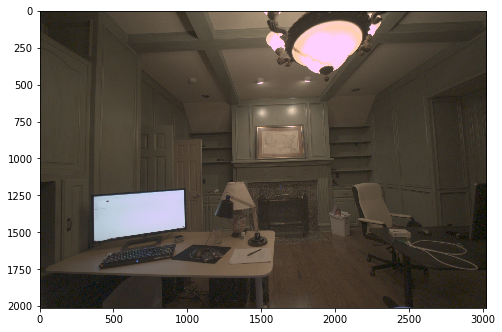

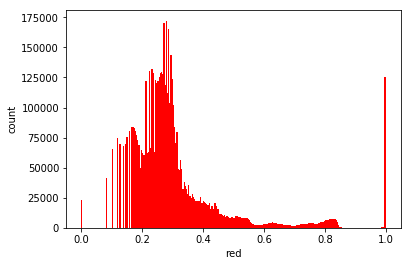

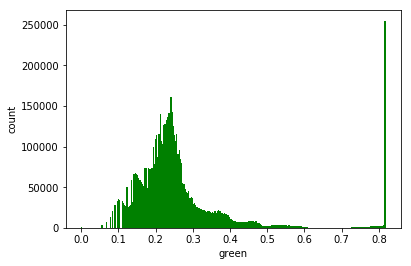

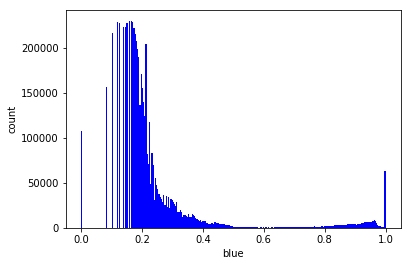

In [8]:
# Step 4: perform gamma correction.
g_correct = normalize(gamma_correction(demosaicked, 0.3))

plt.figure(figsize=(8,16))
plt.imshow(g_correct)

plt.figure()
show_hist(g_correct[:,:,0].reshape([-1]), 256, 'red', color = 'red')
plt.figure()
show_hist(g_correct[:,:,1].reshape([-1]), 256, 'green', color = 'green')
plt.figure()
show_hist(g_correct[:,:,2].reshape([-1]), 256, 'blue', color = 'blue')